In [1]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils/")

import pandas as pd
import pickle
import networkx as nx
from networkx.algorithms.assortativity import average_degree_connectivity, average_neighbor_degree

import matplotlib.pyplot as plt
%matplotlib inline

from get_article_info import *

%aimport get_article_info

In [2]:
with open("../data/interim/02_extracted_basic_numerical_comparison.pkl", "rb") as f:
    wiki_df = pickle.load(f)

In [3]:
wiki_df.columns

Index(['parent_title', 'parent_url', 'child_title', 'child_url', 'comparison',
       'parent_extract', 'parent_links', 'parent_linkshere',
       'parent_categories', 'parent_redirects', 'child_extract', 'child_links',
       'child_linkshere', 'child_categories', 'child_redirects',
       'parent_direct_to_child', 'child_direct_to_parent',
       'parent_path_to_child', 'child_path_to_parent', 'shared_categories',
       'shared_links', 'shared_linkshere'],
      dtype='object')

In [6]:
wiki_nodes = wiki_df[['parent_title', 'parent_url', 'child_title', 'child_url', 'comparison',
       'parent_extract', 'parent_links', 'parent_linkshere',
       'parent_categories', 'parent_redirects', 'child_extract', 'child_links',
       'child_linkshere', 'child_categories', 'child_redirects']]

wiki_nodes.head()

,parent_title,parent_url,child_title,child_url,comparison,parent_extract,parent_links,parent_linkshere,parent_categories,parent_redirects,child_extract,child_links,child_linkshere,child_categories,child_redirects
0,Division_by_Zero_(story),https://en.wikipedia.org/wiki/Division_by_Zero...,Division_by_zero,https://en.wikipedia.org/wiki/Division_by_zero,Division_by_Zero_(story)|Division_by_zero,Division by Zero is a science fiction short st...,"[Amazon.com, Anthology, Bantam Spectra, Consis...","[Division by zero (disambiguation), Stories of...","[Category:1991 short stories, Category:Science...",[],"In mathematics, division by zero is division w...","[0 (number), Alfred Tarski, Algebra, Android (...","[Divide by 0 Error, Division By Zero, Extended...","[Category:0 (number), Category:Computer arithm...","[Divide by zero, One over Zero, One Over Zero,..."
1,Indeterminate_form,https://en.wikipedia.org/wiki/Indeterminate_form,Division_by_zero,https://en.wikipedia.org/wiki/Division_by_zero,Division_by_zero|Indeterminate_form,In calculus and other branches of mathematical...,"[Analytic function, Calculus, Cardinal number,...","[Exponentiation, Indeterminate expression, L'H...",[Category:Limits (mathematics)],"[0/0, Zero divided by zero, 0 divided by 0, In...","In mathematics, division by zero is division w...","[0 (number), Alfred Tarski, Algebra, Android (...","[Divide by 0 Error, Division By Zero, Extended...","[Category:0 (number), Category:Computer arithm...","[Divide by zero, One over Zero, One Over Zero,..."
2,0,https://en.wikipedia.org/wiki/0,Division_by_zero,https://en.wikipedia.org/wiki/Division_by_zero,0|Division_by_zero,0 (zero) is both a number and the numerical di...,"[-1 (number), 0 (disambiguation), 0 (number), ...","[7000 (number), 19 (number), 178 (number), EBC...","[Category:0 (number), Category:Elementary arit...","[Number 0, Nought, Zeroes, Zero (mathematics),...","In mathematics, division by zero is division w...","[0 (number), Alfred Tarski, Algebra, Android (...","[Divide by 0 Error, Division By Zero, Extended...","[Category:0 (number), Category:Computer arithm...","[Divide by zero, One over Zero, One Over Zero,..."
3,Division_by_Zero_(story),https://en.wikipedia.org/wiki/Division_by_Zero...,Infinity,https://en.wikipedia.org/wiki/Infinity,Division_by_Zero_(story)|Infinity,Division by Zero is a science fiction short st...,"[Amazon.com, Anthology, Bantam Spectra, Consis...","[Division by zero (disambiguation), Stories of...","[Category:1991 short stories, Category:Science...",[],Infinity (symbol: \n \n \n \n ...,"[0.999..., 1,000,000, 1,000,000,000, 10,000, 1...","[Iterated binary operation, Bill Childers, Chr...","[Category:CS1: long volume value, Category:Con...","[The Infinite, Infinitely, Infinate, InFINity,..."
4,Indeterminate_form,https://en.wikipedia.org/wiki/Indeterminate_form,Extended_real_number_line,https://en.wikipedia.org/wiki/Extended_real_nu...,Extended_real_number_line|Indeterminate_form,In calculus and other branches of mathematical...,"[Analytic function, Calculus, Cardinal number,...","[Exponentiation, Indeterminate expression, L'H...",[Category:Limits (mathematics)],"[0/0, Zero divided by zero, 0 divided by 0, In...","In mathematics, the affinely extended real num...","[Absolute value, Algebraic number, Arithmetica...","[Number line, L'Hôpital's rule, 1,000,000,000,...","[Category:Infinity, Category:Real numbers]","[Extended real number, Extended reals, Extende..."


# Graph Analysis

In [44]:
def make_graph(row, graph):
    for link in row.parent_links:
        graph.add_edge(row.parent_title, link.replace(" ", "_"))

    for link in row.child_links:
        graph.add_edge(row.child_title, link.replace(" ", "_"))

    for linkhere in row.parent_linkshere:
        graph.add_edge(linkhere.replace(" ", "_"), row.parent_title)

    for linkhere in row.child_linkshere:
        graph.add_edge(linkhere.replace(" ", "_"), row.child_title)

    centrality_dict = nx.betweenness_centrality(graph)

    print("PARENT:\t", centrality_dict[row.parent_title], "\t",
          row.parent_title, f"| links: {len(row.parent_links)}", f"| linkshere: {len(row.parent_linkshere)}")
    print("CHILD:\t", centrality_dict[row.child_title], "\t",
          row.child_title, f"| links: {len(row.child_links)}", f"| linkshere: {len(row.child_linkshere)}")
    
    return sorted([(title, value) for title, value in centrality_dict.items()], key=lambda x: x[1], reverse=True)

In [45]:
def compare_article_centrality(parent, child):

    parent_extract, parent_links, parent_linkshere, parent_categories = get_article_info.get_article_info(parent)
    child_extract, child_links, child_linkshere, child_categories = get_article_info.get_article_info(child)

    comparison = {
        "parent_title": parent, 
        "child_title": child,
        "parent_links": [parent_links],
        "parent_linkshere": [parent_linkshere],
        "child_links": [child_links],
        "child_linkshere": [child_linkshere]

    }

    G = nx.DiGraph()
    return make_graph(pd.DataFrame(comparison).iloc[0], G)


In [47]:
compare_article_centrality("Voice_leading", "Counterpoint")

PARENT:	 0.05513529678232188 	 Voice_leading | links: 108 | linkshere: 135
CHILD:	 0.1293879439702156 	 Counterpoint | links: 140 | linkshere: 1303


[('Counterpoint', 0.1293879439702156),
 ('Voice_leading', 0.05513529678232188),
 ('Accompaniment', 0.0),
 ('Alberti_bass', 0.0),
 ('Anton_Bruckner', 0.0),
 ('Arnold_Schoenberg', 0.0),
 ('Balungan', 0.0),
 ('Banjo_roll', 0.0),
 ('Baroque_music', 0.0),
 ('Basso_continuo', 0.0),
 ('Blind_octave', 0.0),
 ('Block_chord', 0.0),
 ('Cadence_(music)', 0.0),
 ('Canon_(music)', 0.0),
 ('Catch_(music)', 0.0),
 ('Chord_(music)', 0.0),
 ('Chord_progression', 0.0),
 ('Circle_of_fifths', 0.0),
 ('Close_and_open_harmony', 0.0),
 ('Common_practice_period', 0.0),
 ('Common_tone_(chord)', 0.0),
 ('Conjunct_(music)', 0.0),
 ('Consecutive_fifths', 0.0),
 ('Consonance_and_dissonance', 0.0),
 ('Contrary_motion', 0.0),
 ('Diatonic_scale', 0.0),
 ('Disjunct_motion', 0.0),
 ('Dmitri_Tymoczko', 0.0),
 ('English_cadence', 0.0),
 ('False_relation', 0.0),
 ('Figured_bass', 0.0),
 ('First_inversion', 0.0),
 ('Four-part_harmony', 0.0),
 ('Fugue', 0.0),
 ('Function_(music)', 0.0),
 ('Harmonic_rhythm', 0.0),
 ('Harmonic

In [48]:
compare_article_centrality("Cell_(biology)", "Immunology")

PARENT:	 0.09853575395981705 	 Cell_(biology) | links: 373 | linkshere: 2713
CHILD:	 0.08602104802309814 	 Immunology | links: 329 | linkshere: 2116


[('Cell_(biology)', 0.09853575395981705),
 ('Immunology', 0.08602104802309814),
 ('Abiogenesis', 0.0026069043040640788),
 ('Antonie_van_Leeuwenhoek', 0.0026069043040640788),
 ('Bacteria', 0.0026069043040640788),
 ('Biology', 0.0026069043040640788),
 ('Biomolecule', 0.0026069043040640788),
 ('Cell_biology', 0.0026069043040640788),
 ('Cell_type', 0.0026069043040640788),
 ('Enzyme', 0.0026069043040640788),
 ('Genetics', 0.0026069043040640788),
 ('Howard_Hughes_Medical_Institute', 0.0026069043040640788),
 ('Metabolism', 0.0026069043040640788),
 ('Virus', 0.0026069043040640788),
 ('10^12', 0.0),
 ('30S', 0.0),
 ('40S', 0.0),
 ('50S', 0.0),
 ('60S', 0.0),
 ('Abderrazak_El_Albani', 0.0),
 ('Acrosome', 0.0),
 ('Actin', 0.0),
 ('Actinomycetes', 0.0),
 ('Adenosine_triphosphate', 0.0),
 ('Algae', 0.0),
 ('Allium', 0.0),
 ('Amino_acid', 0.0),
 ('Amoeba_(genus)', 0.0),
 ('Amphiphilic', 0.0),
 ('Amyloplast', 0.0),
 ('Anabolism', 0.0),
 ('Anatomical_terminology', 0.0),
 ('Animal', 0.0),
 ('Animal_cel

In [28]:
G = nx.DiGraph()

make_graph(wiki_nodes.iloc[130427], G)

# sorted([(title, value) for title, value in nx.eigenvector_centrality(G).items()], key=lambda x: x[1], reverse=True)

PARENT:	 0.3676036706361683 	 Shinto_music
CHILD:	 0.4625288739647582 	 Traditional_Japanese_musical_instruments


[('Liar_paradox', 0.6148719878633658),
 ('Performative_contradiction', 0.06360219271733433),
 ('Contradiction', 0.0621361640079464),
 ('JSTOR', 0.0621361640079464),
 ('Paradox', 0.0621361640079464),
 ('A._N._Prior', 0.0563115818389547),
 ('Abilene_paradox', 0.0563115818389547),
 ('Alabama_paradox', 0.0563115818389547),
 ('Alfred_Tarski', 0.0563115818389547),
 ('Allais_paradox', 0.0563115818389547),
 ('Ancient_Greek', 0.0563115818389547),
 ('Andrew_David_Irvine', 0.0563115818389547),
 ('Apportionment_paradox', 0.0563115818389547),
 ('Argument_from_free_will', 0.0563115818389547),
 ("Arrow's_impossibility_theorem", 0.0563115818389547),
 ('Arrow_information_paradox', 0.0563115818389547),
 ('Arthur_Prior', 0.0563115818389547),
 ('Ballpoint_pen', 0.0563115818389547),
 ('Barber_paradox', 0.0563115818389547),
 ('Barbershop_paradox', 0.0563115818389547),
 ("Berry's_paradox", 0.0563115818389547),
 ('Berry_paradox', 0.0563115818389547),
 ('Bertrand_paradox_(economics)', 0.0563115818389547),
 ('B

KeyboardInterrupt: 

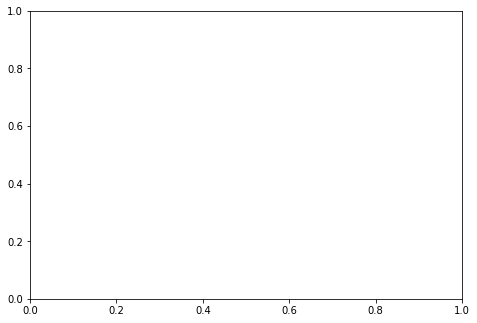

In [113]:

pos = nx.spring_layout(G, dim=10, k=3)
nx.draw(G, alpha=0.3)

In [35]:
G = nx.Graph()

G.add_edge("Bob", "Bill")
G.add_edge("Bob", "Fred")
G.add_edge("Steve", "Fred")
G.add_edge("Sam", "Fred")


/home/qdizon/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


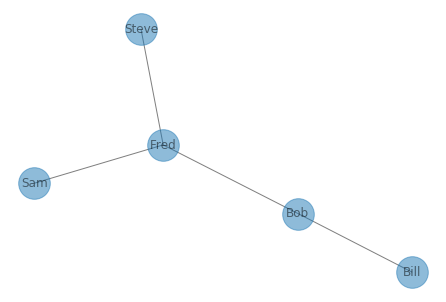

In [36]:
nx.draw(G, with_labels=True, node_size=1000, alpha=0.5)
plt.show()

In [37]:
average_degree_connectivity(G, nodes=["Fred"])

{3: 1.3333333333333333}

In [39]:
average_neighbor_degree(G, nodes=["Bill"])

{'Bill': 2.0}

In [49]:
nx.betweenness_centrality(G)

{'Bob': 0.5, 'Bill': 0.0, 'Fred': 0.8333333333333333, 'Steve': 0.0, 'Sam': 0.0}

In [50]:
nx.eigenvector_centrality(G)

{'Bob': 0.5000017939959851,
 'Bill': 0.27060039404536734,
 'Fred': 0.653280511529063,
 'Steve': 0.35355212204115977,
 'Sam': 0.35355212204115977}